#CL314 Codes, Group 14
## Dhruv Jalan, 23110099
## Antariksh Dongre, 23110031
## Suyog Latke, 23110325


# Velocity Modeling

## Core- Annular Flow

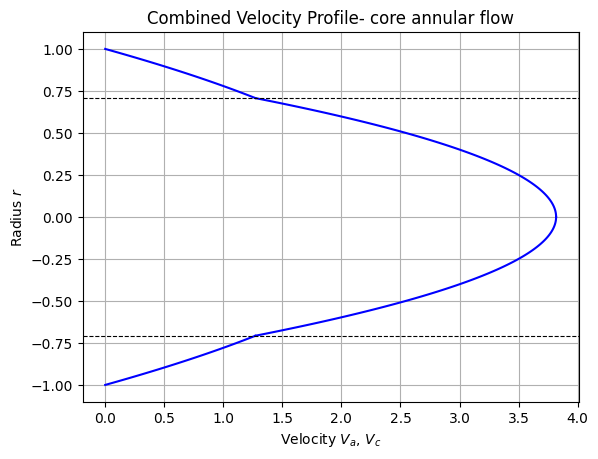

In [84]:
import numpy as np
import matplotlib.pyplot as plt
a = np.sqrt(0.5)
r_outer = np.linspace(a, 1, 100)
v_outer = (((-10.18)/4) * (r_outer**2 - 1))
r_inner = np.linspace(0, a, 100)
v_inner =  4*((((-10.18*0.25 )/4)*(a**2-1)+(-5.09/4)*(r_inner**2-a**2)))
plt.plot(v_outer, r_outer, 'b')
plt.plot(v_inner, r_inner, 'b')
plt.plot(v_outer, -r_outer, 'b')
plt.plot(v_inner, -r_inner, 'b')
plt.xlabel('Velocity $V_{a}$, $V_{c}$')
plt.ylabel('Radius $r$')
plt.axhline(a, color='black', linestyle='--', linewidth=0.8)
plt.axhline(-a, color='black', linestyle='--', linewidth=0.8)
plt.title('Combined Velocity Profile- core annular flow')
plt.grid(True)
plt.show()

## 1D Stratified Flow

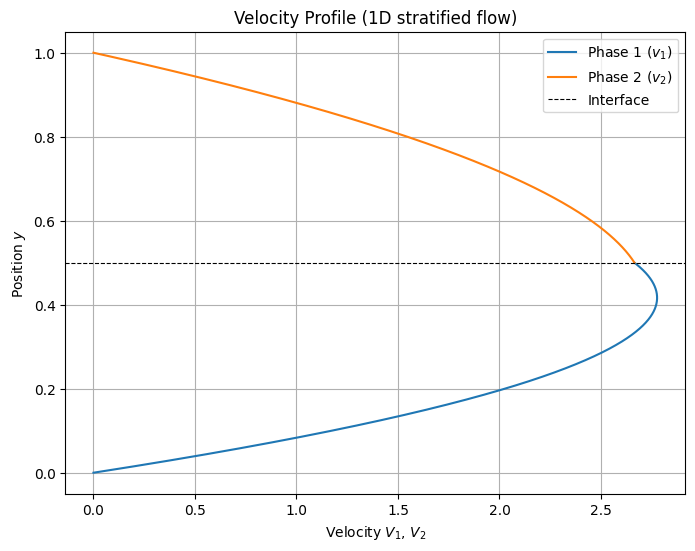

In [85]:
import numpy as np
import matplotlib.pyplot as plt
# values
y1 = np.linspace(0, 0.5, 1000)   # Range for phase 1
y2 = np.linspace(0.5, 1.0, 1000) # Range for phase 2
# Constants
alpha_s = 0.5
G1 = -32
G2 = -19.2
Qr = 0.833
nu_r = 2.0
v1 = (G1 * y1**2) / 2 + (nu_r * y1) * ((G2 * Qr * (alpha_s**2 - 1) - G1 * alpha_s**2)/ (2 * (1 - alpha_s + alpha_s * nu_r)))
term_linear = y2 * (( G1 * alpha_s**2 - G2 * (alpha_s**2 - 1) * Qr) / (2 * Qr * ((alpha_s - 1) - alpha_s * nu_r)))
term_const = (G2 * alpha_s * Qr * ((alpha_s - 1) + nu_r) - G1 * alpha_s**2) / (2 * Qr * ((alpha_s - 1) - alpha_s * nu_r))
v2 = Qr*((G2 * y2**2) / 2 + term_linear + term_const)
plt.figure(figsize=(8, 6))
plt.plot(v1, y1, label='Phase 1 ($v_1$)')
plt.plot(v2, y2, label='Phase 2 ($v_2$)')
plt.xlabel('Velocity $V_1$, $V_2$')
plt.ylabel('Position $y$')
plt.title('Velocity Profile (1D stratified flow)')
plt.axhline(alpha_s, color='black', linestyle='--', linewidth=0.8, label='Interface')
plt.grid(True)
plt.legend()
plt.show()

## 2D Stratified Flow

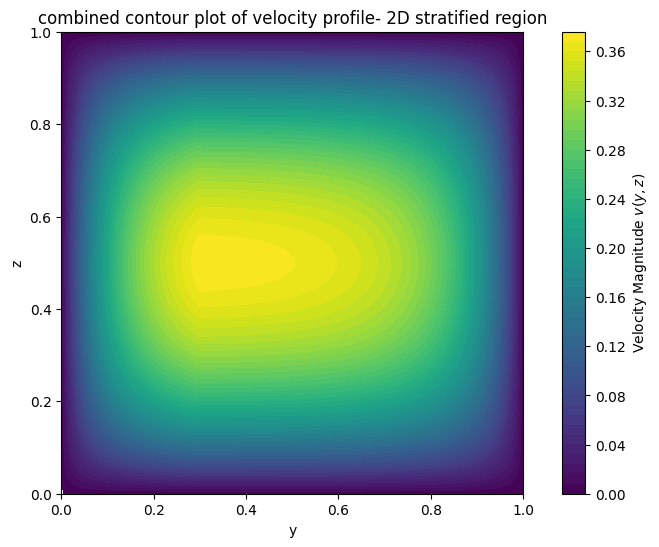

In [86]:
import numpy as np
import matplotlib.pyplot as plt
# Constants
G1 = -32.0
G2 = -19.2
lambda_val = 2.528
N_TERMS = 10
# Grid definitions
Y_SIZE = 50
Z_SIZE = 50
# Region 1: y in [0,0.5]
y1 = np.linspace(0, 0.3, Y_SIZE)
z = np.linspace(0, 1, Z_SIZE)
Y1, Z1 = np.meshgrid(y1, z)
# Region 2: y in [0.5,1]
y2 = np.linspace(0.3, 1, Y_SIZE)
Y2, Z2 = np.meshgrid(y2, z)
V1 = np.zeros_like(Y1, dtype=float)
V2 = np.zeros_like(Y2, dtype=float)
for n in range(1, N_TERMS+1):
    # Common terms
    sine_term1 = np.sin(n*np.pi*Z1)
    sine_term2 = np.sin(n*np.pi*Z2)
    # Region 1 computation
    A1n, A2n = -1, 1
    numerator1 = 2 * G1 * ((-1)**n - 1)
    denom = (n**3)*(np.pi**3)*(lambda_val**2)
    fraction1 = numerator1 / denom
    arg1 = n * np.pi * lambda_val * Y1
    bracket1 = A1n * np.cosh(arg1) + A2n * np.sinh(arg1)+1
    V1 += fraction1 * bracket1 * sine_term1
    # Region 2 computation
    A3n = -(np.exp(-np.pi*n*lambda_val))
    A4n = A3n
    numerator2 = 2*G2*((-1)**n-1)
    fraction2 = numerator2/denom
    arg2 = n*np.pi*lambda_val*Y2
    bracket2 = A3n*np.cosh(arg2)+A4n*np.sinh(arg2)+1
    V2 += fraction2 * bracket2 * sine_term2
V1 = 0.660486301487608*V1
fig, ax = plt.subplots(figsize=(10, 6))
V_full = np.concatenate((V1[:, :-1], V2), axis=1)
Y_full = np.concatenate((Y1[:, :-1], Y2), axis=1)
Z_full = np.concatenate((Z1[:, :-1], Z2), axis=1)
contour = ax.contourf(Y_full, Z_full, V_full, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Velocity Magnitude $v(y, z)$')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f'combined contour plot of velocity profile- 2D stratified region')
ax.set_aspect('equal', adjustable='box')
plt.show()

# Mass- Transfer Modeling

## 1D Stratified Flow - concentration + mass balance verification



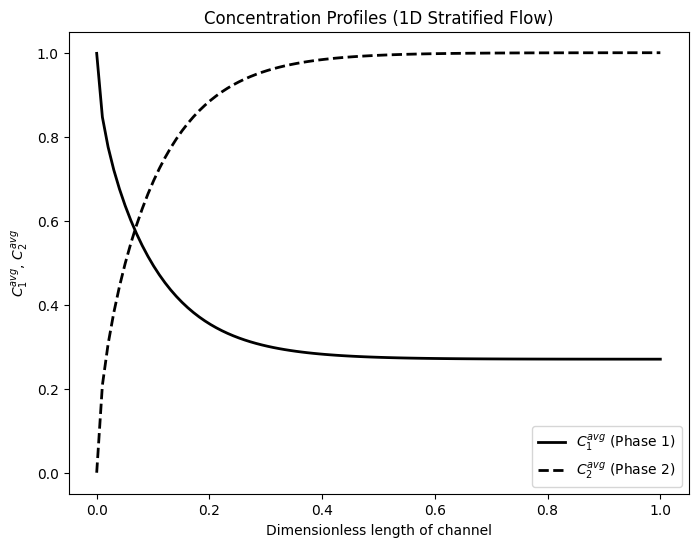

In [87]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
import matplotlib.pyplot as plt
qr      = 0.7283
mu_r    = 3.0
mu1     = 1.0
mu2     = mu1 * mu_r
alpha_s = 0.5011
Pe1     = 114.75
Pe2     = 222.85
lamb     = 0.005
Dr      = 2.6667
ks      = 0.2703
g1      = -38.06
g2      = -17.42
coeff1 = 1/ (lamb*Pe1)
coeff2 = 1/(lamb* Pe2)
N1 = 50
N2 = 50
y1 = np.linspace(0, alpha_s, N1)
y2 = np.linspace(alpha_s, 1, N2)
dy1 = y1[1] - y1[0]
dy2 = y2[1] - y2[0]
def get_v1(y):
    denom = 2 * (1 - alpha_s + alpha_s*mu_r)
    term_mid = (g2 * qr * (alpha_s**2 - 1) - g1*(alpha_s**2))/denom
    v = (g1 * y**2) / 2 + mu_r*term_mid * y
    return np.abs(v)
def get_v2(y):
    denom = 2*qr*((alpha_s - 1)*mu1 - alpha_s*mu2)
    term1 = (g1 * alpha_s**2 - g2 * (alpha_s**2 - 1) * qr) / denom
    term2 = (g2 * alpha_s * qr * ((alpha_s - 1)*mu1 + mu2) - g1 * alpha_s**2 * mu1) / denom
    v = qr*((g2 * y**2) / 2 + term1 * y + term2)
    return np.abs(v)
# Calculate velocities and clamp
v1_vals = np.maximum(get_v1(y1), 1e-6)
v2_vals = np.maximum(get_v2(y2), 1e-6)
# Calculate Flow Rates for Mixing Cup Average
Q1_calc = trapezoid(v1_vals, y1)
Q2_calc = trapezoid(v2_vals, y2)
# Ode function to calculate the MOL
def odefunc(x, C):
    dCdx = np.zeros_like(C)
    c1 = C[:N1]
    c2 = C[N1:]
    # Interface Handling
    c1_prev = c1[-2]
    c2_next = c2[1]
    D1 = 1/(lamb*Pe1)
    D2 = 1/(lamb*Pe2)
    numerator = (D1 * c1_prev / dy1) + (D2 * c2_next / dy2)
    denominator = (D1 * ks / dy1) + (D2 / dy2)
    v_interface = numerator /denominator # Phase 2 interface value
    u_interface = ks * v_interface        # Phase 1 interface value
    # phase 1 mol calculations
    d2c1 =(c1[:-2] - 2*c1[1:-1] + c1[2:])/dy1**2
    dCdx[1:N1-1]= (coeff1 / v1_vals[1:-1]) * d2c1
    dCdx[0]  = (coeff1 / v1_vals[0]) * (2*c1[1] - 2*c1[0]) / dy1**2
    dCdx[N1-1]=(coeff1/v1_vals[-1])*(c1_prev-2*c1[-1]+u_interface)/dy1**2
    # phase 2 mol calculations
    d2c2 = (c2[:-2] - 2*c2[1:-1] + c2[2:]) / dy2**2
    dCdx[N1+1:-1] = (coeff2 / v2_vals[1:-1]) * d2c2
    dCdx[N1] = (coeff2 / v2_vals[0]) * (v_interface - 2*c2[0] + c2_next) / dy2**2
    dCdx[-1] =(coeff2 / v2_vals[-1])*(2*c2[-2] - 2*c2[-1]) / dy2**2
    return dCdx
C0 = np.zeros(N1 + N2)
C0[:N1] = 1
C0[N1:] = 0
x_eval = np.linspace(0, 1, 100)
sol = solve_ivp(odefunc, [0, 1], C0, t_eval=x_eval, method='BDF', rtol=1e-5, atol=1e-8)
# using the mixing cup average from reference [9]
c1_avgs = []
c2_avgs = []
for i in range(len(sol.t)):
    C_step = sol.y[:, i]
    flux1 = trapezoid(C_step[:N1] * v1_vals, y1)
    flux2 = trapezoid(C_step[N1:] * v2_vals, y2)
    c1_avgs.append(flux1/Q1_calc)
    c2_avgs.append(flux2/Q2_calc)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, c1_avgs, 'k-', linewidth=2, label=r'$C_1^{avg}$ (Phase 1)')
plt.plot(sol.t, c2_avgs, 'k--', linewidth=2, label=r'$C_2^{avg}$ (Phase 2)')
plt.xlabel('Dimensionless length of channel')
plt.ylabel(r'$C^{avg}_{1}$, $C^{avg}_{2}$')
plt.title('Concentration Profiles (1D Stratified Flow)')
plt.legend()
plt.show()

### Mass balance verification - 1D stratified


 Running Mass Balance Verification for 1d stratified flows
Initial Phase 1 flux: 0.99427506
Initial Phase 2 flux: 0.00000000
Initial Total flux:   0.99427506
Final Phase 1 flux:   0.26920552
Final Phase 2 flux:   0.72507005
Final Total flux:     0.99427557
Max Residual Error:   5.10e-07


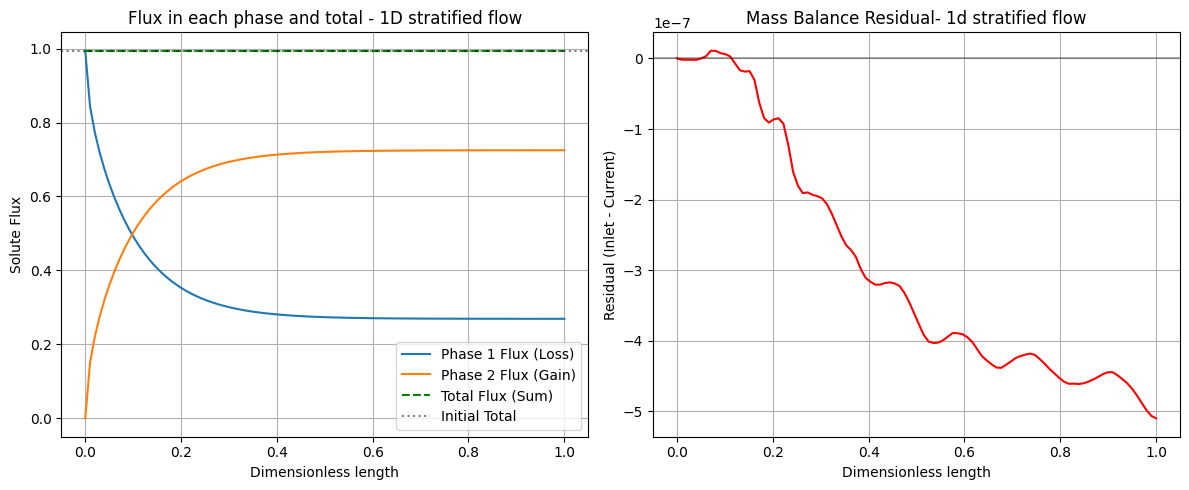

In [88]:
print("\n Running Mass Balance Verification for 1d stratified flows")
flux1_list = []
flux2_list = []
total_flux_list = []
for i in range(len(sol.t)):
    C_step = sol.y[:, i]
    c1_step = C_step[:N1]
    c2_step = C_step[N1:]

    # Flux = Integral( Velocity * Concentration * dy )
    flux1 = trapezoid(c1_step * v1_vals, y1)
    flux2 = trapezoid(c2_step * v2_vals, y2)
    flux1_list.append(flux1)
    flux2_list.append(flux2)
    total_flux_list.append(flux1 + flux2)
flux1_arr = np.array(flux1_list)
flux2_arr = np.array(flux2_list)
total_flux_arr = np.array(total_flux_list)
initial_mass = total_flux_arr[0]
residual = initial_mass - total_flux_arr
print(f"Initial Phase 1 flux: {flux1_arr[0]:.8f}")
print(f"Initial Phase 2 flux: {flux2_arr[0]:.8f}")
print(f"Initial Total flux:   {initial_mass:.8f}")
print(f"Final Phase 1 flux:   {flux1_arr[-1]:.8f}")
print(f"Final Phase 2 flux:   {flux2_arr[-1]:.8f}")
print(f"Final Total flux:     {total_flux_arr[-1]:.8f}")
print(f"Max Residual Error:   {np.max(np.abs(residual)):.2e}")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sol.t, flux1_arr, label='Phase 1 Flux (Loss)')
plt.plot(sol.t, flux2_arr, label='Phase 2 Flux (Gain)')
plt.plot(sol.t, total_flux_arr, 'g--', label='Total Flux (Sum)')
plt.axhline(y=initial_mass, color='k', linestyle=':', alpha=0.5, label='Initial Total')
plt.xlabel('Dimensionless length')
plt.ylabel('Solute Flux')
plt.title('Flux in each phase and total - 1D stratified flow')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(sol.t, residual, 'r-', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Dimensionless length')
plt.ylabel('Residual (Inlet - Current)')
plt.title('Mass Balance Residual- 1d stratified flow')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2D Stratified Flow - concentration + mass balance verification

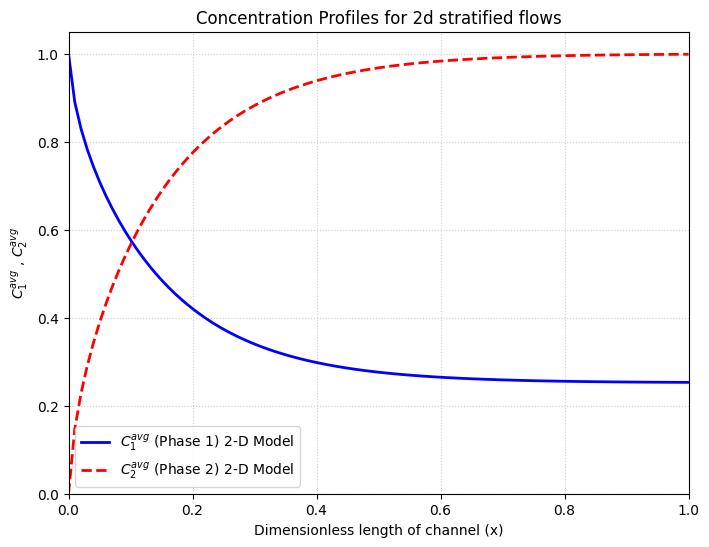

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
qr      = 0.7283
mu_r    = 3.0
mu1     = 1.0
mu2     = mu1 * mu_r
Dr      = 2.6667
alpha_s = 0.5        # Interface position
g1      = -4.12      # Pressure gradient Phase 1
g2      = -1.88      # Pressure gradient Phase 2
Pe1     = 6.88       # Peclet Phase 1
Pe2     = 13.37      # Peclet Phase 2
lamb    = 0.1        # Aspect ratio (lambda)
ks      = 0.2703     # Partition coefficient
D1_val = 1.0 / Pe1
D2_val = 1.0 / Pe2
N1 = 25   # Y-grid Phase 1
N2 = 25   # Y-grid Phase 2
Nz = 15   # Z-grid (Axis 1)
# Y-grids (Axis 0)
y1 = np.linspace(0, alpha_s, N1)
y2 = np.linspace(alpha_s, 1, N2)
dy1 = y1[1] - y1[0]
dy2 = y2[1] - y2[0]
# Z-grid
z = np.linspace(0, 1, Nz)
dz = z[1] - z[0]
# Create meshgrids for 2D calculation
Y1, Z1 = np.meshgrid(y1, z, indexing='ij')
Y2, Z2 = np.meshgrid(y2, z, indexing='ij')
v1_2d = np.zeros((N1, Nz))
v2_2d = np.zeros((N2, Nz))
n_terms = 51
for n in range(1, n_terms, 2):
    k_n = n * np.pi * lamb
    denom = (n**3) * (np.pi**3) * (lamb**2)
    P1_n = (2*g1*(-2))/denom
    P2_n = (2*g2*(-2))/denom
    A1n = -1.0
    C_s = np.cosh(k_n * alpha_s) # Cosh at interface
    S_s = np.sinh(k_n * alpha_s) # Sinh at interface
    C_1 = np.cosh(k_n * 1.0)     # Cosh at top wall
    S_1 = np.sinh(k_n * 1.0)     # Sinh at top wall
    A_mat = np.zeros((3, 3))
    b_vec = np.zeros(3)
    A_mat[0, 0] = 0.0       # Coeff of A2n
    A_mat[0, 1] = C_1       # Coeff of A3n
    A_mat[0, 2] = S_1       # Coeff of A4n
    b_vec[0]    = -1.0
    A_mat[1, 0] = P1_n * S_s
    A_mat[1, 1] = -P2_n * C_s
    A_mat[1, 2] = -P2_n * S_s
    b_vec[1]    = P2_n - P1_n + (P1_n * C_s)
    A_mat[2, 0] = mu1 * P1_n * C_s
    A_mat[2, 1] = -mu2 * P2_n * S_s
    A_mat[2, 2] = -mu2 * P2_n * C_1
    A_mat[2, 2] = -mu2 * P2_n * C_s
    b_vec[2]    = mu1 * P1_n * S_s
    x_sol = np.linalg.solve(A_mat, b_vec)
    A2n, A3n, A4n = x_sol[0], x_sol[1], x_sol[2]
    term1_y = P1_n * (A1n * np.cosh(k_n * Y1) + A2n * np.sinh(k_n * Y1) + 1)
    term1_z = np.sin(n * np.pi * Z1)
    v1_2d += term1_y * term1_z
    term2_y = P2_n * (A3n * np.cosh(k_n * Y2) + A4n * np.sinh(k_n * Y2) + 1)
    term2_z = np.sin(n * np.pi * Z2)
    v2_2d += term2_y * term2_z
v1_2d = np.abs(v1_2d)
v2_2d = np.abs(v2_2d)
Q1_calc = trapezoid([trapezoid(v1_2d[i, :], z) for i in range(N1)], y1)
Q2_calc = trapezoid([trapezoid(v2_2d[i, :], z) for i in range(N2)], y2)
def odefunc(x, C_flat):
    # Unpack
    split_idx = N1 * Nz
    c1 = C_flat[:split_idx].reshape((N1, Nz))
    c2 = C_flat[split_idx:].reshape((N2, Nz))
    d2c1_dz2 = np.zeros_like(c1)
    d2c1_dz2[:, 1:-1] = (c1[:, 0:-2] - 2*c1[:, 1:-1] + c1[:, 2:]) / dz**2
    d2c1_dz2[:, 0]    = 2*(c1[:, 1] - c1[:, 0]) / dz**2    # No flux z=0
    d2c1_dz2[:, -1]   = 2*(c1[:, -2] - c1[:, -1]) / dz**2  # No flux z=1
    d2c2_dz2 = np.zeros_like(c2)
    d2c2_dz2[:, 1:-1] = (c2[:, 0:-2] - 2*c2[:, 1:-1] + c2[:, 2:]) / dz**2
    d2c2_dz2[:, 0]    = 2*(c2[:, 1] - c2[:, 0]) / dz**2
    d2c2_dz2[:, -1]   = 2*(c2[:, -2] - c2[:, -1]) / dz**2
    c1_prev = c1[-2,:]
    c2_next = c2[1,:]
    numerator = (D1_val * c1_prev / dy1) + (D2_val * c2_next / dy2)
    denominator = (D1_val * ks / dy1) + (D2_val / dy2)
    v_interface = numerator/denominator
    u_interface = ks*v_interface
    d2c1_dy2 = np.zeros_like(c1)
    d2c1_dy2[1:-1, :] = (c1[:-2, :] - 2*c1[1:-1, :] + c1[2:, :]) / dy1**2
    d2c1_dy2[0, :]    = 2*(c1[1, :] - c1[0, :]) / dy1**2
    d2c1_dy2[-1, :]   = (c1_prev - 2*c1[-1, :] + u_interface) / dy1**2
    d2c2_dy2 = np.zeros_like(c2)
    d2c2_dy2[1:-1, :] = (c2[:-2, :] - 2*c2[1:-1, :] + c2[2:, :]) / dy2**2
    d2c2_dy2[0, :]    = (v_interface - 2*c2[0, :] + c2_next) / dy2**2
    d2c2_dy2[-1, :]   = 2*(c2[-2, :] - c2[-1, :]) / dy2**2
    lam_sq = lamb**2
    # Adding a small epsilon to velocity to avoid division by zero at walls
    v1_safe = np.maximum(v1_2d, 1e-9)
    v2_safe = np.maximum(v2_2d, 1e-9)
    dc1_dx = (D1_val / v1_safe) * (d2c1_dy2 + lam_sq * d2c1_dz2)
    dc2_dx = (D2_val / v2_safe) * (d2c2_dy2 + lam_sq * d2c2_dz2)
    return np.concatenate((dc1_dx.flatten(), dc2_dx.flatten()))
# solving
C1_0 = np.ones((N1, Nz))
C2_0 = np.zeros((N2, Nz))
C0_flat = np.concatenate((C1_0.flatten(), C2_0.flatten()))
x_eval = np.linspace(0, 1, 100)
sol = solve_ivp(odefunc, [0, 1], C0_flat, t_eval=x_eval, method='BDF', rtol=1e-3, atol=1e-5)
c1_avgs_2d = []
c2_avgs_2d = []
split_idx = N1 * Nz
C2_equilibrium = Q1_calc/(Q1_calc * ks + Q2_calc)
for i in range(len(sol.t)):
    C_step = sol.y[:, i]
    c1_step = C_step[:split_idx].reshape((N1, Nz))
    c2_step = C_step[split_idx:].reshape((N2, Nz))
    flux1_z = [trapezoid(c1_step[j, :] * v1_2d[j, :], z) for j in range(N1)]
    flux1_total = trapezoid(flux1_z, y1)
    flux2_z = [trapezoid(c2_step[j, :] * v2_2d[j, :], z) for j in range(N2)]
    flux2_total = trapezoid(flux2_z, y2)
    c2_actual = flux2_total/Q2_calc
    c2_normalized = c2_actual/C2_equilibrium
    c1_avgs_2d.append(flux1_total/Q1_calc)
    c2_avgs_2d.append(c2_normalized)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, c1_avgs_2d, 'b-', linewidth=2, label=r'$C_1^{avg}$ (Phase 1) 2-D Model')
plt.plot(sol.t, c2_avgs_2d, 'r--', linewidth=2, label=r'$C_2^{avg}$ (Phase 2) 2-D Model')
plt.xlabel('Dimensionless length of channel (x)')
plt.ylabel(r'$C^{avg}_1$ , $C^{avg}_2$')
plt.title('Concentration Profiles for 2d stratified flows')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

### Mass Balance verification for 2d stratified flow

Initial Phase 1 Flux : 0.10888503
Initial Phase 2 Flux : 0.00000000
Initial Total Flux   : 0.10888503
Final Phase 1 Flux   : 0.02755734
Final Phase 2 Flux   : 0.08132769
Final Total Flux     : 0.10888503
Max Residual Error   : 8.78e-10


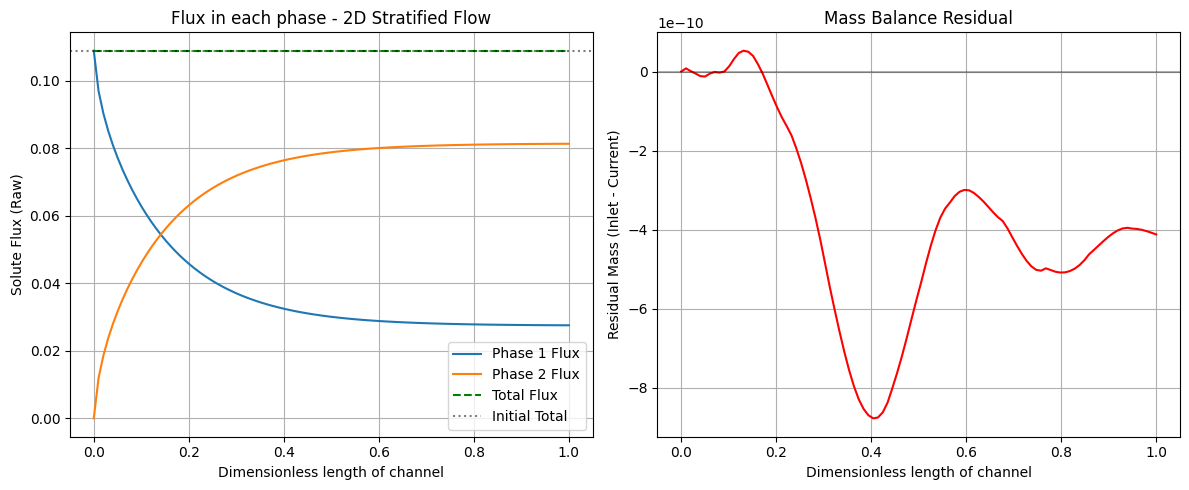

In [90]:
def check_mass_balance(sol, N1, N2, Nz, y1, y2, z, v1_2d, v2_2d):
    flux1_list = []
    flux2_list = []
    total_flux_list = []
    split_idx = N1*Nz
    # --- Calculate Raw Fluxes ---
    for i in range(len(sol.t)):
        C_step = sol.y[:, i]
        # Reshape flat array to 2D grids
        c1_step = C_step[:split_idx].reshape((N1, Nz))
        c2_step = C_step[split_idx:].reshape((N2, Nz))
        # Integrate Phase 1
        flux1_z = [trapezoid(c1_step[j, :] * v1_2d[j, :], z) for j in range(N1)]
        flux1 = trapezoid(flux1_z, y1)
        # Integrate Phase 2
        flux2_z = [trapezoid(c2_step[j, :] * v2_2d[j, :], z) for j in range(N2)]
        flux2 = trapezoid(flux2_z, y2)
        flux1_list.append(flux1)
        flux2_list.append(flux2)
        total_flux_list.append(flux1 + flux2)
    # Convert to arrays (Raw values, NO division)
    flux1_arr = np.array(flux1_list)
    flux2_arr = np.array(flux2_list)
    total_flux_arr = np.array(total_flux_list)
    # Calculate Residual based on initial raw mass
    initial_mass = total_flux_arr[0]
    residual = initial_mass - total_flux_arr
    # --- Print Raw Statistics ---
    print(f"Initial Phase 1 Flux : {flux1_arr[0]:.8f}")
    print(f"Initial Phase 2 Flux : {flux2_arr[0]:.8f}")
    print(f"Initial Total Flux   : {total_flux_arr[0]:.8f}")
    print(f"Final Phase 1 Flux   : {flux1_arr[-1]:.8f}")
    print(f"Final Phase 2 Flux   : {flux2_arr[-1]:.8f}")
    print(f"Final Total Flux     : {total_flux_arr[-1]:.8f}")
    print(f"Max Residual Error   : {np.max(np.abs(residual)):.2e}")
    # --- Plotting ---
    plt.figure(figsize=(12, 5))
    # Plot 1: Raw Fluxes
    plt.subplot(1, 2, 1)
    plt.plot(sol.t, flux1_arr, label='Phase 1 Flux')
    plt.plot(sol.t, flux2_arr, label='Phase 2 Flux')
    plt.plot(sol.t, total_flux_arr, 'g--', label='Total Flux')
    # Horizontal line at Initial Mass (instead of 1.0)
    plt.axhline(y=initial_mass, color='k', linestyle=':', alpha=0.5, label='Initial Total')
    plt.xlabel('Dimensionless length of channel')
    plt.ylabel('Solute Flux (Raw)')
    plt.title('Flux in each phase - 2D Stratified Flow')
    plt.legend()
    plt.grid(True)
    # Plot 2: Residuals
    plt.subplot(1, 2, 2)
    plt.plot(sol.t, residual, 'r-', linewidth=1.5)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Dimensionless length of channel')
    plt.ylabel('Residual Mass (Inlet - Current)')
    plt.title('Mass Balance Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Call the function
check_mass_balance(sol, N1, N2, Nz, y1, y2, z, v1_2d, v2_2d)

### Combining 2 cases of 1d stratified and 2d stratified flows

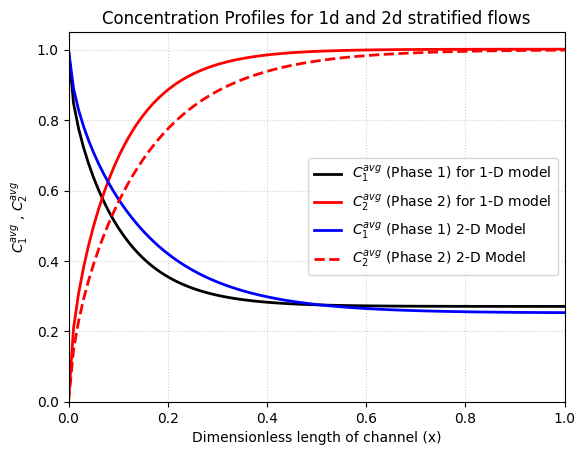

In [91]:
plt.plot(sol.t, c1_avgs, 'k-', linewidth=2, label=r'$C_1^{avg}$ (Phase 1) for 1-D model')
plt.plot(sol.t, c2_avgs, 'r-', linewidth=2, label=r'$C_2^{avg}$ (Phase 2) for 1-D model')
plt.plot(sol.t, c1_avgs_2d, 'b-', linewidth=2, label=r'$C_1^{avg}$ (Phase 1) 2-D Model')
plt.plot(sol.t, c2_avgs_2d, 'r--', linewidth=2, label=r'$C_2^{avg}$ (Phase 2) 2-D Model')
plt.xlabel('Dimensionless length of channel (x)')
plt.ylabel(r'$C^{avg}_1$ , $C^{avg}_2$')
plt.title('Concentration Profiles for 1d and 2d stratified flows')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Core- Annular Flow -concentration + mass balance verification

### Core- annular concentration variation when $C_{c}^{in} = 1$

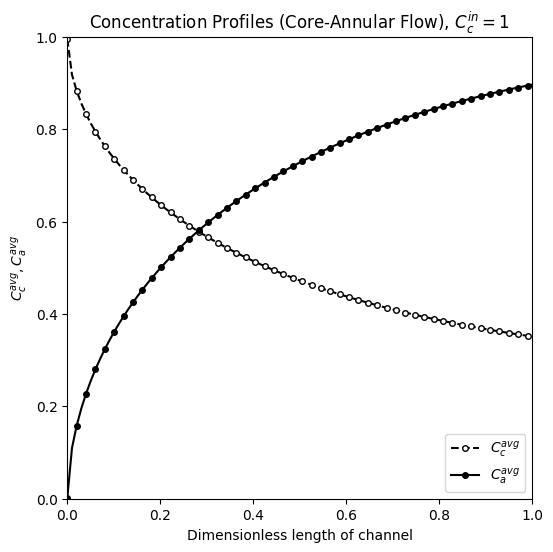

In [92]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
import matplotlib.pyplot as plt
Qr      = 0.7283
mu_r    = 3.0
Dr      = 2.6667
a       = 0.7038
Gc      = -35.27
Ga      = -16.14
Pec     = 2.19
Pea     = 4.26
K_ca    = 0.2703
N_core = 80
N_ann  = 80
al = 1.85
r_c = np.linspace(0, a, N_core + 1)
r_a = np.linspace(a, 1, N_ann + 1)
dr_c = r_c[1] - r_c[0]
dr_a = r_a[1] - r_a[0]
def get_vc(r):
    term1 = (Ga*Qr/4.0)*(a**2-1)
    term2 = (Gc/4.0)*(r**2-a**2)
    return np.abs(term1 + term2)
def get_va(r):
    return np.abs((Ga/4.0)*(r**2-1))
vc_vals = np.maximum(get_vc(r_c), 1e-6)
va_vals = np.maximum(get_va(r_a), 1e-6)
vc_vals = Qr*vc_vals
Qc_calc = trapezoid(vc_vals * r_c, r_c)
Qa_calc = trapezoid(va_vals * r_a, r_a)
def odefunc(z, C_flat):
    c_core_pts = C_flat[:N_core]      # Indices 0..N_core-1
    c_ann_pts  = C_flat[N_core:]      # Indices 0..N_ann-1
    dCdz_c = np.zeros(N_core)
    dCdz_a = np.zeros(N_ann)
    c_c_last = c_core_pts[-1]  # Point just before interface
    c_a_first = c_ann_pts[0]   # Point just after interface
    # Solve for C_a_interface (C_int_a)
    # K * C_int_a / dr_c + Dr * C_int_a / dr_a = C_c_last / dr_c + Dr * C_a_first / dr_a
    denom = (K_ca / dr_c) + (Dr / dr_a)
    numer = (c_c_last / dr_c) + (Dr * c_a_first / dr_a)
    c_int_a = numer / denom
    c_int_c = K_ca * c_int_a
    c_c_full = np.concatenate([c_core_pts, [c_int_c]])
    laplacian_center = 4.0 * (c_c_full[1] - c_c_full[0]) / dr_c**2
    dCdz_c[0] = (1.0 / (vc_vals[0] * Pec)) * laplacian_center
    c_curr = c_c_full[1:-1]
    c_prev = c_c_full[:-2]
    c_next = c_c_full[2:]
    r_curr = r_c[1:-1]
    d2c = (c_next - 2*c_curr + c_prev) / dr_c**2
    dc  = (c_next - c_prev) / (2 * dr_c)
    dCdz_c[1:] = (1.0 / (vc_vals[1:-1] * Pec)) * (d2c + (1.0/r_curr)*dc)
    c_a_full = np.concatenate([[c_int_a], c_ann_pts])
    c_curr_a = c_a_full[1:-1]
    c_prev_a = c_a_full[:-2]
    c_next_a = c_a_full[2:]
    r_curr_a = r_a[1:-1]
    d2c_a = (c_next_a - 2*c_curr_a + c_prev_a) / dr_a**2
    dc_a  = (c_next_a - c_prev_a) / (2 * dr_a)
    dCdz_a[:-1] = (1.0/((Qr/2)*va_vals[1:-1]*Pea)) * (d2c_a + (1.0/r_curr_a)*dc_a)
    c_wall = c_a_full[-1]
    c_prev_wall = c_a_full[-2]
    laplacian_wall = 2.0 * (c_prev_wall - c_wall) / dr_a**2
    dCdz_a[-1] =(1.0/(va_vals[-1]*Pea))*laplacian_wall
    return np.concatenate([dCdz_c, dCdz_a])
# Initial Conditions: Core = 1, Annulus = 0
C0 = np.concatenate([np.ones(N_core), np.zeros(N_ann)])
z_eval = np.linspace(0, 1, 100)
sol = solve_ivp(odefunc, [0, 1], C0, t_eval=z_eval, method='BDF', rtol=1e-6, atol=1e-9)
# using the average from reference [9]
c_core_avgs = []
c_ann_avgs = []
for i in range(len(sol.t)):
    C_step = sol.y[:, i]
    c_c_pts = C_step[:N_core]
    c_a_pts = C_step[N_core:]
    c_c_last =c_c_pts[-1]
    c_a_first =c_a_pts[0]
    denom = (K_ca/dr_c) + (Dr/dr_a)
    numer = (c_c_last/dr_c) + (Dr*c_a_first/dr_a)
    c_int_a = numer/denom
    c_int_c= K_ca*c_int_a
    c_c_full = np.concatenate([c_c_pts, [c_int_c]])
    c_a_full = np.concatenate([[c_int_a], c_a_pts])
    flux_c = trapezoid(c_c_full*vc_vals*r_c, r_c)
    flux_a = trapezoid(c_a_full*va_vals*r_a, r_a)
    c_core_avgs.append(flux_c/Qc_calc)
    c_ann_avgs.append(flux_a/Qa_calc)
plt.figure(figsize=(6, 6))
plt.plot(sol.t, c_core_avgs, 'k--o',markersize=4,mfc='white',linewidth=1.5,markevery=2,label=r'$C_c^{avg}$')
plt.plot(sol.t, c_ann_avgs, 'k-o',markersize=4,linewidth=1.5,markevery=2,label=r'$C_a^{avg}$')
plt.xlabel('Dimensionless length of channel')
plt.ylabel(r'$C_c^{avg}, C_a^{avg}$')
plt.title(r'Concentration Profiles (Core-Annular Flow), $C_c^{in} = 1$')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()

### Mass balance in case of $C_{c}^{in} = 1$

Initial Core Flux :    0.65814537
Initial Annulus Flux : 0.00074294
Initial Total Flux :   0.65888831
Final Core Flux :      0.23217268
Final Annulus Flux:   0.42604692
Final Total Flux:     0.65821960
Max Residual Error:          6.69e-04


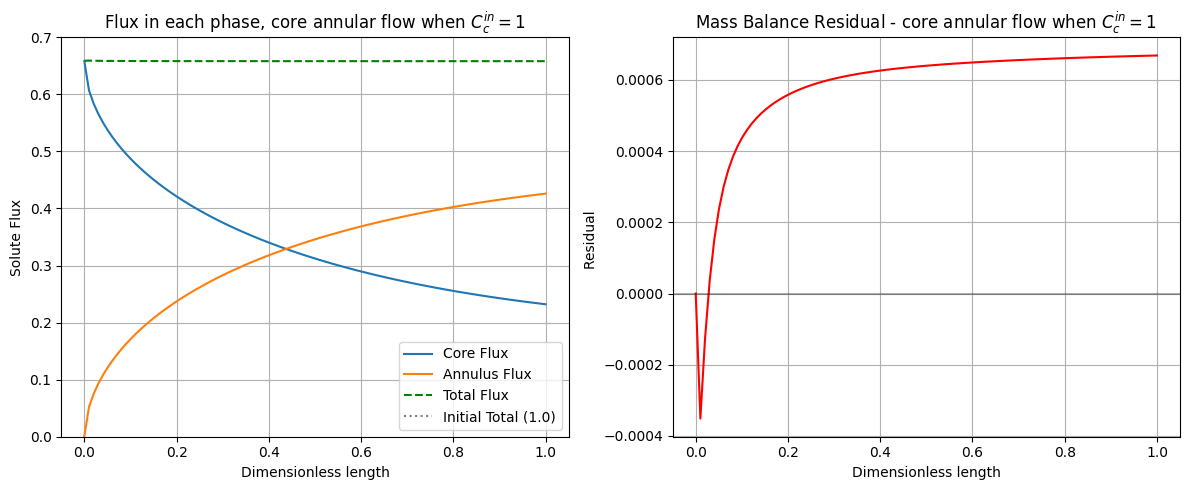

In [93]:
flux_c_list = []
flux_a_list = []
total_flux_list = []
for i in range(len(sol.t)):
    C_step = sol.y[:, i]
    c_c_pts = C_step[:N_core]
    c_a_pts = C_step[N_core:]
    c_c_last = c_c_pts[-1]
    c_a_first = c_a_pts[0]
    denom = (K_ca / dr_c) + (Dr / dr_a)
    numer = (c_c_last / dr_c) + (Dr * c_a_first / dr_a)
    c_int_a = numer / denom
    c_int_c = K_ca * c_int_a
    c_c_full = np.concatenate([c_c_pts, [c_int_c]])
    c_a_full = np.concatenate([[c_int_a], c_a_pts])
    flux_c = trapezoid(c_c_full * vc_vals * r_c, r_c)
    flux_a = trapezoid(c_a_full * 1.85*va_vals * r_a, r_a)
    flux_c_list.append(flux_c)
    flux_a_list.append(flux_a)
    total_flux_list.append(flux_c + flux_a)
inlet_mass = total_flux_list[0]
flux_c_arr = np.array(flux_c_list) /1
flux_a_arr = np.array(flux_a_list) / 1
total_flux_arr = np.array(total_flux_list) / 1
residual = inlet_mass - total_flux_arr
print(f"Initial Core Flux :    {flux_c_arr[0]:.8f}")
print(f"Initial Annulus Flux : {flux_a_arr[0]:.8f}")
print(f"Initial Total Flux :   {total_flux_arr[0]:.8f}")
print(f"Final Core Flux :      {flux_c_arr[-1]:.8f}")
print(f"Final Annulus Flux:   {flux_a_arr[-1]:.8f}")
print(f"Final Total Flux:     {total_flux_arr[-1]:.8f}")
print(f"Max Residual Error:          {np.max(np.abs(residual)):.2e}")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sol.t, flux_c_arr, label='Core Flux')
plt.plot(sol.t, flux_a_arr, label='Annulus Flux')
plt.plot(sol.t, total_flux_arr, 'g--', label='Total Flux')
plt.axhline(y=1.0, color='k', linestyle=':', alpha=0.5, label='Initial Total (1.0)')
plt.ylim([0, 0.7])
plt.xlabel('Dimensionless length')
plt.ylabel('Solute Flux')
plt.title('Flux in each phase, core annular flow when $C_{c}^{in} = 1$')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(sol.t, residual, 'r-', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Dimensionless length')
plt.ylabel('Residual ')
plt.title('Mass Balance Residual - core annular flow when $C_{c}^{in} = 1$')
plt.grid(True)

plt.tight_layout()
plt.show()

### Core- annular concentration variation when $C_{a}^{in} = 1$

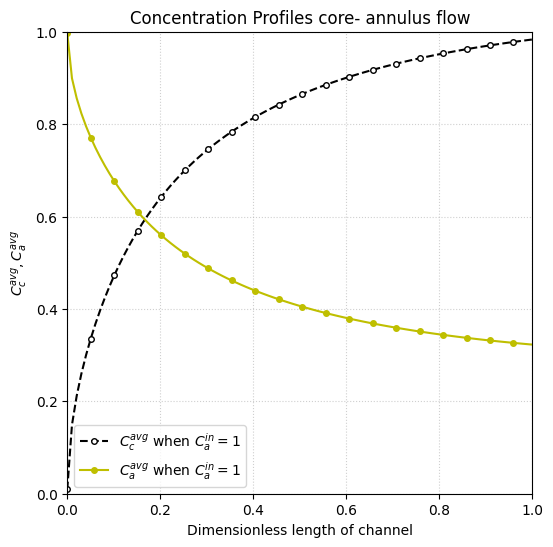

In [94]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
import matplotlib.pyplot as plt
Qr      = 0.7283
mu_r    = 3.0
Dr      = 2.6667
a       = 0.7038
Gc      = -35.27
Ga      = -16.14
Pec     = 2.19
Pea     = 4.26
K_ca_original = 0.2703
K_ca = 1.0 / K_ca_original
N_core = 100
N_ann  = 100
r_c = np.linspace(0, a, N_core + 1)
r_a = np.linspace(a, 1, N_ann + 1)
dr_c = r_c[1] - r_c[0]
dr_a = r_a[1] - r_a[0]
def get_vc(r):
    term1 = (Ga * Qr / 4.0) * (a**2 - 1)
    term2 = (Gc / 4.0) * (r**2 - a**2)
    return np.abs(term1 + term2)
def get_va(r):
    return np.abs((Ga / 4.0) * (r**2 - 1))
vc_vals = np.maximum(get_vc(r_c), 1e-6)
va_vals = np.maximum(get_va(r_a), 1e-6)
Qc_calc = trapezoid(vc_vals * r_c, r_c)
Qa_calc = trapezoid(va_vals * r_a, r_a)
def odefunc(z, C_flat):
    c_core_pts = C_flat[:N_core]
    c_ann_pts  = C_flat[N_core:]
    dCdz_c = np.zeros(N_core)
    dCdz_a = np.zeros(N_ann)
    c_c_last = c_core_pts[-1]
    c_a_first = c_ann_pts[0]
    denom = (K_ca / dr_c) + (Dr / dr_a)
    numer = (c_c_last / dr_c) + (Dr * c_a_first / dr_a)
    c_int_a = numer / denom
    c_int_c = K_ca * c_int_a
    c_c_full = np.concatenate([c_core_pts, [c_int_c]])
    laplacian_center=4.0*(c_c_full[1]-c_c_full[0])/dr_c**2
    dCdz_c[0]=(1.0/(vc_vals[0]*Pec))*laplacian_center
    c_curr = c_c_full[1:-1]
    c_prev = c_c_full[:-2]
    c_next = c_c_full[2:]
    r_curr = r_c[1:-1]
    d2c = (c_next - 2*c_curr + c_prev) / dr_c**2
    dc  = (c_next - c_prev) / (2 * dr_c)
    dCdz_c[1:] = (1.0 / (vc_vals[1:-1] * Pec)) * (d2c + (1.0/r_curr)*dc)
    c_a_full = np.concatenate([[c_int_a], c_ann_pts])
    c_curr_a = c_a_full[1:-1]
    c_prev_a = c_a_full[:-2]
    c_next_a = c_a_full[2:]
    r_curr_a = r_a[1:-1]
    d2c_a = (c_next_a - 2*c_curr_a + c_prev_a) / dr_a**2
    dc_a  = (c_next_a - c_prev_a) / (2 * dr_a)
    dCdz_a[:-1] = (1.0 / (va_vals[1:-1] * Pea)) * (d2c_a + (1.0/r_curr_a)*dc_a)
    c_wall = c_a_full[-1]
    c_prev_wall = c_a_full[-2]
    laplacian_wall = 2.0 * (c_prev_wall - c_wall) / dr_a**2
    dCdz_a[-1] = (1.0 / (va_vals[-1] * Pea)) * laplacian_wall
    return np.concatenate([dCdz_c, dCdz_a])
# Initial Conditions: Core = 0, Annulus = 1
C0 = np.concatenate([np.zeros(N_core), np.ones(N_ann)])
z_eval = np.linspace(0, 1, 100)
sol = solve_ivp(odefunc, [0, 1], C0, t_eval=z_eval, method='BDF', rtol=1e-6, atol=1e-9)
c_core_avgs_2 = []
c_ann_avgs_2 = []
for i in range(len(sol.t)):
    C_step = sol.y[:, i]
    c_c_pts = C_step[:N_core]
    c_a_pts = C_step[N_core:]
    c_c_last = c_c_pts[-1]
    c_a_first = c_a_pts[0]
    denom = (K_ca / dr_c) + (Dr / dr_a)
    numer = (c_c_last / dr_c) + (Dr * c_a_first / dr_a)
    c_int_a = numer / denom
    c_int_c = K_ca * c_int_a
    c_c_full = np.concatenate([c_c_pts, [c_int_c]])
    c_a_full = np.concatenate([[c_int_a], c_a_pts])
    # Mixing Cup Integrals
    flux_c = trapezoid(c_c_full*vc_vals*r_c,r_c)
    flux_a = trapezoid(c_a_full*va_vals*r_a,r_a)
    c_core_avgs_2.append(flux_c/Qc_calc)
    c_ann_avgs_2.append(flux_a/Qa_calc)
plt.figure(figsize=(6, 6))
plt.plot(sol.t, c_core_avgs_2, 'k--o', markersize=4, mfc='white', linewidth=1.5, markevery=5, label=r'$C_c^{avg}$ when $C_{a}^{in} = 1$')
plt.plot(sol.t, c_ann_avgs_2, 'y-o', markersize=4, linewidth=1.5, markevery=5, label=r'$C_a^{avg}$ when $C_{a}^{in} = 1$')
plt.xlabel('Dimensionless length of channel')
plt.ylabel(r'$C_c^{avg}, C_a^{avg}$')
plt.title('Concentration Profiles core- annulus flow')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.show()

### Mass balance verification for $C_{a}^{in} = 1$

Initial Core Flux:      0.00624843 (Should be 0)
Initial Annulus Flux:   0.95279967 (Should be > 0)
Initial Total Flux:     0.95904810
Final Core Flux:        0.65025552
Final Annulus Flux:     0.30849150
Final Total Flux:       0.95874701
Max Residual Error:     1.10e-03


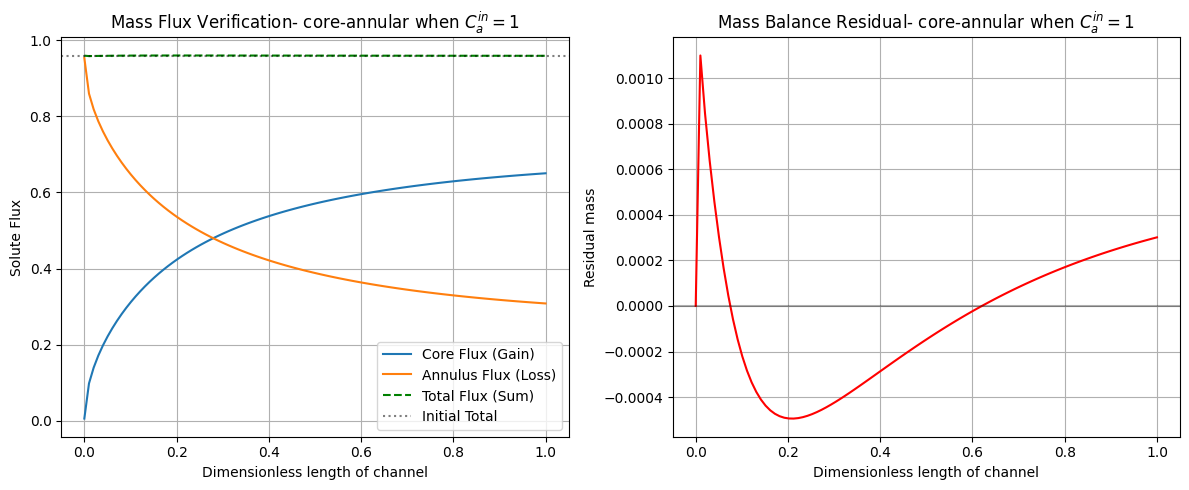

In [95]:
flux_c_list = []
flux_a_list = []
total_flux_list =[]
for i in range(len(sol.t)):
    C_step =sol.y[:, i]
    c_c_pts =C_step[:N_core]
    c_a_pts =C_step[N_core:]
    c_c_last =c_c_pts[-1]
    c_a_first =c_a_pts[0]
    denom = (K_ca/dr_c) +(Dr/dr_a)
    numer = (c_c_last/dr_c)+(Dr*c_a_first/dr_a)
    c_int_a = numer/denom
    c_int_c = K_ca*c_int_a
    c_c_full = np.concatenate([c_c_pts, [c_int_c]])
    c_a_full = np.concatenate([[c_int_a], c_a_pts])
    flux_c = trapezoid(c_c_full*vc_vals*(Qr)*r_c,r_c)
    flux_a = trapezoid(c_a_full*3.72*va_vals*r_a,r_a)
    flux_c_list.append(flux_c)
    flux_a_list.append(flux_a)
    total_flux_list.append(flux_c + flux_a)
flux_c_arr = np.array(flux_c_list)
flux_a_arr = np.array(flux_a_list)
total_flux_arr = np.array(total_flux_list)
initial_mass = total_flux_arr[0]
residual = initial_mass - total_flux_arr
print(f"Initial Core Flux:      {flux_c_arr[0]:.8f} (Should be 0)")
print(f"Initial Annulus Flux:   {flux_a_arr[0]:.8f} (Should be > 0)")
print(f"Initial Total Flux:     {initial_mass:.8f}")
print(f"Final Core Flux:        {flux_c_arr[-1]:.8f}")
print(f"Final Annulus Flux:     {flux_a_arr[-1]:.8f}")
print(f"Final Total Flux:       {total_flux_arr[-1]:.8f}")
print(f"Max Residual Error:     {np.max(np.abs(residual)):.2e}")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sol.t, flux_c_arr, label='Core Flux (Gain)')
plt.plot(sol.t, flux_a_arr, label='Annulus Flux (Loss)')
plt.plot(sol.t, total_flux_arr, 'g--', label='Total Flux (Sum)')
plt.axhline(y=initial_mass, color='k', linestyle=':', alpha=0.5, label='Initial Total')
plt.xlabel('Dimensionless length of channel')
plt.ylabel('Solute Flux')
plt.title('Mass Flux Verification- core-annular when $C_{a}^{in} = 1$')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(sol.t, residual, 'r-', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Dimensionless length of channel')
plt.ylabel('Residual mass')
plt.title('Mass Balance Residual- core-annular when $C_{a}^{in} = 1$')
plt.grid(True)
plt.tight_layout()
plt.show()

### Combining 2 cases of core annulus flow in one single plot

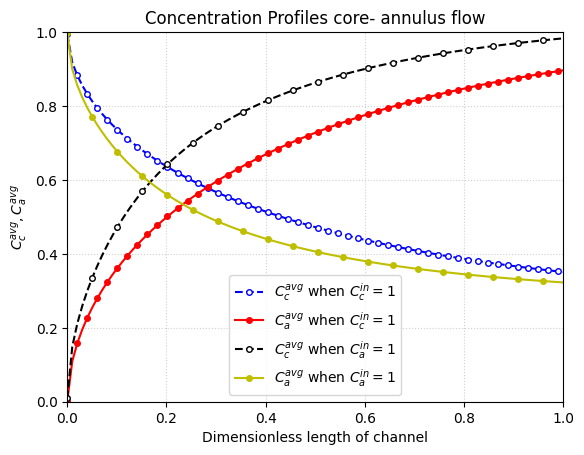

In [96]:
plt.plot(sol.t, c_core_avgs, 'b--o',markersize=4,mfc='white',linewidth=1.5,markevery=2,label=r'$C_c^{avg}$ when $C_{c}^{in} = 1$')
plt.plot(sol.t, c_ann_avgs, 'r-o',markersize=4,linewidth=1.5,markevery=2,label=r'$C_a^{avg}$ when $C_{c}^{in} = 1$')
plt.plot(sol.t, c_core_avgs_2, 'k--o', markersize=4, mfc='white', linewidth=1.5, markevery=5, label=r'$C_c^{avg}$ when $C_{a}^{in} = 1$')
plt.plot(sol.t, c_ann_avgs_2, 'y-o', markersize=4, linewidth=1.5, markevery=5, label=r'$C_a^{avg}$ when $C_{a}^{in} = 1$')
plt.xlabel('Dimensionless length of channel')
plt.ylabel(r'$C_c^{avg}, C_a^{avg}$')
plt.title('Concentration Profiles core- annulus flow')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(0, 1.0)
plt.xlim(0, 1.0)
plt.show()

# Extraction Metrics

## Extraction Metric Generator Functions

### Stratified 1D Flows

In [97]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
import matplotlib.pyplot as plt
def ER_1dstrat(qr, mu_r, mu1,e, alpha_s, Pe1, Pe2, lamb, Dr, ks, g1, g2, N1, N2):
    #Simulates 1D stratified flow and returns the Dimensionless Length and Extraction Ratio.
    mu2 = mu1 * mu_r
    coeff1 = 1 / (e * lamb * Pe1)
    coeff2 = 1 / (e* lamb * Pe2)
    y1 = np.linspace(0, alpha_s, N1)
    y2 = np.linspace(alpha_s, 1, N2)
    dy1 = y1[1] - y1[0]
    dy2 = y2[1] - y2[0]
    # calculating the velocity at every y
    def get_v1(y):
        denom = 2 * (1 - alpha_s + alpha_s * mu_r)
        term_mid = (g2 * qr * (alpha_s**2 - 1) - g1 * (alpha_s**2)) / denom
        v = (g1 * y**2) / 2 + mu_r * term_mid * y
        return np.abs(v)
    def get_v2(y):
        denom = 2 * qr * ((alpha_s - 1) * mu1 - alpha_s * mu2)
        term1 = (g1 * alpha_s**2 - g2 * (alpha_s**2 - 1) * qr) / denom
        term2 = (g2 * alpha_s * qr * ((alpha_s - 1) * mu1 + mu2) - g1 * alpha_s**2 * mu1) / denom
        v = qr * ((g2 * y**2) / 2 + term1 * y + term2)
        return np.abs(v)
    v1_vals = np.maximum(get_v1(y1), 1e-6)
    v2_vals = np.maximum(get_v2(y2), 1e-6)
    Q1_calc = trapezoid(v1_vals, y1)
    Q2_calc = trapezoid(v2_vals, y2)
    # solving of Method of lines
    def odefunc(x, C):
        dCdx = np.zeros_like(C)
        c1 = C[:N1]
        c2 = C[N1:]
        # Interface Handling
        c1_prev = c1[-2]
        c2_next = c2[1]
        D1 = 1 / (lamb * Pe1)
        D2 = 1 / (lamb * Pe2)
        numerator = (D1 * c1_prev / dy1) + (D2 * c2_next / dy2)
        denominator = (D1 * ks / dy1) + (D2 / dy2)
        v_interface = numerator / denominator
        u_interface = ks * v_interface
        # Phase 1 mol calculations
        d2c1 = (c1[:-2] - 2 * c1[1:-1] + c1[2:]) / dy1**2
        dCdx[1:N1-1] = (coeff1 / v1_vals[1:-1]) * d2c1
        dCdx[0] = (coeff1 / v1_vals[0]) * (2 * c1[1] - 2 * c1[0]) / dy1**2
        dCdx[N1-1] = (coeff1 / v1_vals[-1]) * (c1_prev - 2 * c1[-1] + u_interface) / dy1**2
        # Phase 2 mol calculations
        d2c2 =(c2[:-2]-2*c2[1:-1]+c2[2:])/dy2**2
        dCdx[N1+1:-1] =(coeff2/v2_vals[1:-1])*d2c2
        dCdx[N1] =(coeff2/v2_vals[0])*(v_interface-2*c2[0]+c2_next)/dy2**2
        dCdx[-1] =(coeff2/v2_vals[-1])*(2*c2[-2]-2*c2[-1])/dy2**2
        return dCdx
    C0 = np.zeros(N1 + N2)
    C0[:N1] = 1.0
    C0[N1:] = 0.0
    x_eval = np.linspace(0, 1, 100)
    sol = solve_ivp(odefunc, [0, 1], C0, t_eval=x_eval, method='BDF', rtol=1e-5, atol=1e-8)
    c2_avgs = []
    for i in range(len(sol.t)):
        C_step = sol.y[:, i]
        flux2 = trapezoid(C_step[N1:] * v2_vals, y2)
        c2_avgs.append(flux2 / Q2_calc)
    c1_in = 1
    # Calculating the extraction ratios for the given 1D stratfied flow
    ER = (np.array(c2_avgs) * Q2_calc) / (c1_in * Q1_calc)
    return sol.t, ER

### Stratified 2D Flows

In [98]:
import numpy as np
from scipy.integrate import solve_ivp

def ER_2dstrat(qr, mu_r, mu1, e, alpha_s, Pe1, Pe2, lamb, Dr, ks, g1, g2, N1, N2, Nz):
    D1_val = 1.0 / e*Pe1
    D2_val = 1.0 / e*Pe2

    y1 = np.linspace(0, alpha_s, N1)
    y2 = np.linspace(alpha_s, 1, N2)
    dy1 = y1[1] - y1[0]
    dy2 = y2[1] - y2[0]

    # Z-grid
    z = np.linspace(0, 1, Nz)
    dz = z[1] - z[0]

    # Create meshgrids for 2D calculation
    Y1, Z1 = np.meshgrid(y1, z, indexing='ij')
    Y2, Z2 = np.meshgrid(y2, z, indexing='ij')

    # --- 3. Velocity Profiles (2D Series Solution) ---
    v1_2d = np.zeros((N1, Nz))
    v2_2d = np.zeros((N2, Nz))

    # Number of terms
    n_terms = 51

    for n in range(1, n_terms, 2):
        # Constants for this mode
        k_n = n * np.pi * lamb
        if k_n > 30:
            break
        denom = (n**3) * (np.pi**3) * (lamb**2)
        P1_n = (2 * g1 * (-2)) / denom
        P2_n = (2 * g2 * (-2)) / denom
        A1n = -1.0
        C_s = np.cosh(k_n * alpha_s)
        S_s = np.sinh(k_n * alpha_s)
        C_1 = np.cosh(k_n * 1.0)
        S_1 = np.sinh(k_n * 1.0)
        A_mat = np.zeros((3, 3))
        b_vec = np.zeros(3)
        A_mat[0, 0] = 0.0
        A_mat[0, 1] = C_1
        A_mat[0, 2] = S_1
        b_vec[0]    = -1.0
        A_mat[1, 0] = P1_n * S_s
        A_mat[1, 1] = -P2_n * C_s
        A_mat[1, 2] = -P2_n * S_s
        b_vec[1]    = P2_n - P1_n + (P1_n * C_s)
        A_mat[2, 0] = mu1 * P1_n * C_s
        A_mat[2, 1] = -mu2 * P2_n * S_s
        A_mat[2, 2] = -mu2 * P2_n * C_s
        b_vec[2]    = mu1 * P1_n * S_s
        x_sol = np.linalg.lstsq(A_mat, b_vec, rcond=None)[0]
        A2n, A3n, A4n = x_sol[0], x_sol[1], x_sol[2]
        term1_y = P1_n * (A1n * np.cosh(k_n * Y1) + A2n * np.sinh(k_n * Y1) + 1)
        term1_z = np.sin(n * np.pi * Z1)
        v1_2d += term1_y * term1_z
        term2_y = P2_n * (A3n * np.cosh(k_n * Y2) + A4n * np.sinh(k_n * Y2) + 1)
        term2_z = np.sin(n * np.pi * Z2)
        v2_2d += term2_y * term2_z
    v1_2d = np.abs(v1_2d)
    v2_2d = np.abs(v2_2d)
    Q1_calc = trapezoid([trapezoid(v1_2d[i, :], z) for i in range(N1)], y1)
    Q2_calc = trapezoid([trapezoid(v2_2d[i, :], z) for i in range(N2)], y2)
    def odefunc(x, C_flat):
        # Unpack
        split_idx = N1 * Nz
        c1 = C_flat[:split_idx].reshape((N1, Nz))
        c2 = C_flat[split_idx:].reshape((N2, Nz))
        d2c1_dz2 = np.zeros_like(c1)
        d2c1_dz2[:, 1:-1] = (c1[:, 0:-2] - 2*c1[:, 1:-1] + c1[:, 2:]) / dz**2
        d2c1_dz2[:, 0]    = 2*(c1[:, 1] - c1[:, 0]) / dz**2
        d2c1_dz2[:, -1]   = 2*(c1[:, -2] - c1[:, -1]) / dz**2
        d2c2_dz2 = np.zeros_like(c2)
        d2c2_dz2[:, 1:-1] = (c2[:, 0:-2] - 2*c2[:, 1:-1] + c2[:, 2:]) / dz**2
        d2c2_dz2[:, 0]    = 2*(c2[:, 1] - c2[:, 0]) / dz**2
        d2c2_dz2[:, -1]   = 2*(c2[:, -2] - c2[:, -1]) / dz**2
        c1_prev = c1[-2,:]
        c2_next = c2[1,:]
        numerator = (D1_val * c1_prev / dy1) + (D2_val * c2_next / dy2)
        denominator = (D1_val * ks / dy1) + (D2_val / dy2)
        v_interface = numerator/denominator
        u_interface = ks*v_interface
        d2c1_dy2 = np.zeros_like(c1)
        d2c1_dy2[1:-1, :] = (c1[:-2, :] - 2*c1[1:-1, :] + c1[2:, :]) / dy1**2
        d2c1_dy2[0, :]    = 2*(c1[1, :] - c1[0, :]) / dy1**2
        d2c1_dy2[-1, :]   = (c1_prev - 2*c1[-1, :] + u_interface) / dy1**2
        d2c2_dy2 = np.zeros_like(c2)
        d2c2_dy2[1:-1, :] = (c2[:-2, :] - 2*c2[1:-1, :] + c2[2:, :]) / dy2**2
        d2c2_dy2[0, :]    = (v_interface - 2*c2[0, :] + c2_next) / dy2**2
        d2c2_dy2[-1, :]   = 2*(c2[-2, :] - c2[-1, :]) / dy2**2
        # assembling
        lam_sq = lamb**2
        v1_safe = np.maximum(v1_2d, 1e-9)
        v2_safe = np.maximum(v2_2d, 1e-9)
        dc1_dx = (D1_val / (e*v1_safe)) * (d2c1_dy2 + lam_sq * d2c1_dz2)
        dc2_dx = (D2_val / (e*v2_safe)) * (d2c2_dy2 + lam_sq * d2c2_dz2)
        return np.concatenate((dc1_dx.flatten(), dc2_dx.flatten()))
    C1_0 = np.ones((N1, Nz))
    C2_0 = np.zeros((N2, Nz))
    C0_flat = np.concatenate((C1_0.flatten(), C2_0.flatten()))
    x_eval = np.linspace(0, 1, 100)
    sol = solve_ivp(odefunc, [0, 1], C0_flat, t_eval=x_eval, method='BDF', rtol=1e-9, atol=1e-5)
    c1_avgs_2d = []
    c2_avgs_2d = []
    split_idx = N1 * Nz
    # Avoid div by zero if Qs are 0
    if Q1_calc == 0: Q1_calc = 1e-9
    if Q2_calc == 0: Q2_calc = 1e-9
    C2_equilibrium = Q1_calc / (Q1_calc * ks + Q2_calc)
    for i in range(len(sol.t)):
        C_step = sol.y[:, i]
        c1_step = C_step[:split_idx].reshape((N1, Nz))
        c2_step = C_step[split_idx:].reshape((N2, Nz))
        flux1_z = [trapezoid(c1_step[j, :] * v1_2d[j, :], z) for j in range(N1)]
        flux1_total = trapezoid(flux1_z, y1)
        flux2_z = [trapezoid(c2_step[j, :] * v2_2d[j, :], z) for j in range(N2)]
        flux2_total = trapezoid(flux2_z, y2)
        c2_actual = flux2_total / Q2_calc
        c2_normalized = c2_actual / C2_equilibrium
        c1_avgs_2d.append(flux1_total / Q1_calc)
        c2_avgs_2d.append(c2_normalized)
    c1_in = 1
    ER = (np.array(c2_avgs_2d) * Q2_calc) / (c1_in * Q1_calc)
    return sol.t, ER

### Core-annular flows

In [99]:
# when cc_in = 1
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
import matplotlib.pyplot as plt
def ER_coreannular(Qr,mu_r,Dr,a,Gc,Ga,Pec,Pea,K_ca,e, N_core, N_ann):
    """Simulates Core-Annular flow (Carrier in Core) and calculates Extraction Ratio."""
    r_c = np.linspace(0, a, N_core + 1)
    r_a = np.linspace(a, 1, N_ann + 1)
    dr_c = r_c[1] - r_c[0]
    dr_a = r_a[1] - r_a[0]
    def get_vc(r):
        term1 = (Ga*Qr/4.0)*(a**2-1)
        term2 = (Gc/4.0)*(r**2 - a**2)
        return np.abs(term1 + term2)
    def get_va(r):
        return np.abs((Ga / 4.0) * (r**2 - 1))
    vc_vals = np.maximum(get_vc(r_c), 1e-6)
    va_vals = np.maximum(get_va(r_a), 1e-6)
    vc_vals = Qr * vc_vals
    # Calculate Flow Rates (Weighted by r for cylindrical coordinates)
    Qc_calc = trapezoid(vc_vals * r_c, r_c)
    Qa_calc = trapezoid(va_vals * r_a, r_a)
    # implementing the method of lines
    def odefunc(z, C_flat):
        c_core_pts = C_flat[:N_core]
        c_ann_pts  = C_flat[N_core:]
        dCdz_c = np.zeros(N_core)
        dCdz_a = np.zeros(N_ann)
        c_c_last = c_core_pts[-1]
        c_a_first = c_ann_pts[0]
        # Algebraic solve for interface
        denom = (K_ca/dr_c)+(Dr/dr_a)
        numer = (c_c_last/dr_c)+(Dr * c_a_first / dr_a)
        c_int_a = numer / denom
        c_int_c = K_ca * c_int_a
        c_c_full = np.concatenate([c_core_pts, [c_int_c]])
        # Center (L'Hopital)
        laplacian_center = 4.0 * (c_c_full[1] - c_c_full[0]) / dr_c**2
        dCdz_c[0] = (1.0 / (vc_vals[0] * Pec)) * laplacian_center
        # Interior
        c_curr = c_c_full[1:-1]
        c_prev = c_c_full[:-2]
        c_next = c_c_full[2:]
        r_curr = r_c[1:-1]
        d2c = (c_next - 2*c_curr + c_prev) / dr_c**2
        dc  = (c_next - c_prev) / (2 * dr_c)
        dCdz_c[1:] = (1.0 / (vc_vals[1:-1] * Pec)) * (d2c + (1.0/r_curr)*dc)
        # --- Annulus Equations ---
        c_a_full = np.concatenate([[c_int_a], c_ann_pts])
        # Interior
        c_curr_a = c_a_full[1:-1]
        c_prev_a = c_a_full[:-2]
        c_next_a = c_a_full[2:]
        r_curr_a = r_a[1:-1]

        d2c_a = (c_next_a - 2*c_curr_a + c_prev_a) / dr_a**2
        dc_a  = (c_next_a - c_prev_a) / (2 * dr_a)
        # Note: Preserving the specific (Qr/2) scaling from input code
        dCdz_a[:-1] = (1.0/(e*va_vals[1:-1]*Pea)) * (d2c_a + (1.0/r_curr_a)*dc_a)
        # Wall
        c_wall = c_a_full[-1]
        c_prev_wall = c_a_full[-2]
        laplacian_wall = 2.0 * (c_prev_wall - c_wall) / dr_a**2
        dCdz_a[-1] = (1.0/(e*va_vals[-1]*Pea))*laplacian_wall
        return np.concatenate([dCdz_c, dCdz_a])
    C0 = np.concatenate([np.ones(N_core), np.zeros(N_ann)])
    z_eval = np.linspace(0, 1, 100)
    sol = solve_ivp(odefunc, [0, 1], C0, t_eval=z_eval, method='BDF', rtol=1e-6, atol=1e-9)
    c_core_avgs = []
    c_ann_avgs = []
    for i in range(len(sol.t)):
        C_step = sol.y[:, i]
        c_c_pts = C_step[:N_core]
        c_a_pts = C_step[N_core:]
        c_c_last = c_c_pts[-1]
        c_a_first = c_a_pts[0]
        denom = (K_ca/dr_c) + (Dr/dr_a)
        numer = (c_c_last/dr_c) + (Dr*c_a_first/dr_a)
        c_int_a = numer/denom
        c_int_c = K_ca*c_int_a
        c_c_full = np.concatenate([c_c_pts, [c_int_c]])
        c_a_full = np.concatenate([[c_int_a], c_a_pts])
        flux_c = trapezoid(c_c_full * vc_vals * r_c, r_c)
        flux_a = trapezoid(c_a_full * va_vals * r_a, r_a)
        c_core_avgs.append(flux_c / Qc_calc)
        c_ann_avgs.append(flux_a / Qa_calc)
    c_carrier_in = 1.0
    ER = (np.array(c_ann_avgs) * Qa_calc)/(c_carrier_in*Qc_calc)
    return sol.t, ER

In [100]:
# when ca_in = 1
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
import matplotlib.pyplot as plt

def ER_coreannular_ca(Qr,mu_r,Dr,a,Gc,Ga,Pec,Pea,K_ca,e, N_core, N_ann):
  r_c = np.linspace(0, a, N_core + 1)
  r_a = np.linspace(a, 1, N_ann + 1)
  K_ca = 1.0 / K_ca
  dr_c = r_c[1] - r_c[0]
  dr_a = r_a[1] - r_a[0]

  # --- 3. Velocity Profiles ---
  def get_vc(r):
      term1 = (Ga * Qr / 4.0) * (a**2 - 1)
      term2 = (Gc / 4.0) * (r**2 - a**2)
      return np.abs(term1 + term2)

  def get_va(r):
      return np.abs((Ga / 4.0) * (r**2 - 1))

  vc_vals = np.maximum(get_vc(r_c), 1e-6)
  va_vals = np.maximum(get_va(r_a), 1e-6)

  Qc_calc = trapezoid(vc_vals * r_c, r_c)
  Qa_calc = trapezoid(va_vals * r_a, r_a)

  # --- 4. ODE Function ---
  def odefunc(z, C_flat):
      # Split state vector
      c_core_pts = C_flat[:N_core]
      c_ann_pts  = C_flat[N_core:]

      dCdz_c = np.zeros(N_core)
      dCdz_a = np.zeros(N_ann)

      # --- Interface Coupling ---
      c_c_last = c_core_pts[-1]  # Adjacent to interface
      c_a_first = c_ann_pts[0]   # Adjacent to interface
      denom = (K_ca / dr_c) + (Dr / dr_a)
      numer = (c_c_last / dr_c) + (Dr * c_a_first / dr_a)
      c_int_a = numer / denom
      c_int_c = K_ca * c_int_a
      # --- Core PDE Discretization ---
      c_c_full = np.concatenate([c_core_pts, [c_int_c]])
      # 1. Center (r=0)
      laplacian_center = 4.0 * (c_c_full[1] - c_c_full[0]) / dr_c**2
      dCdz_c[0] = (1.0 / (vc_vals[0] * Pec)) * laplacian_center
      # 2. Core Interior
      c_curr = c_c_full[1:-1]
      c_prev = c_c_full[:-2]
      c_next = c_c_full[2:]
      r_curr = r_c[1:-1]
      d2c = (c_next - 2*c_curr + c_prev) / dr_c**2
      dc  = (c_next - c_prev) / (2 * dr_c)
      dCdz_c[1:] = (1.0 / (e*vc_vals[1:-1] * Pec)) * (d2c + (1.0/r_curr)*dc)
      c_a_full = np.concatenate([[c_int_a], c_ann_pts])
      c_curr_a = c_a_full[1:-1]
      c_prev_a = c_a_full[:-2]
      c_next_a = c_a_full[2:]
      r_curr_a = r_a[1:-1]
      d2c_a = (c_next_a - 2*c_curr_a + c_prev_a) / dr_a**2
      dc_a  = (c_next_a - c_prev_a) / (2 * dr_a)
      dCdz_a[:-1] = (1.0 / (va_vals[1:-1] * Pea)) * (d2c_a + (1.0/r_curr_a)*dc_a)
      # 2. Wall (r=1)
      c_wall = c_a_full[-1]
      c_prev_wall = c_a_full[-2]
      laplacian_wall = 2.0 * (c_prev_wall - c_wall) / dr_a**2
      dCdz_a[-1] = (1.0 / (va_vals[-1] * Pea)) * laplacian_wall
      return np.concatenate([dCdz_c, dCdz_a])
  C0 = np.concatenate([np.zeros(N_core), np.ones(N_ann)])
  z_eval = np.linspace(0, 1, 100)
  sol = solve_ivp(odefunc, [0, 1], C0, t_eval=z_eval, method='BDF', rtol=1e-6, atol=1e-9)
  c_core_avgs = []
  c_ann_avgs = []
  for i in range(len(sol.t)):
      C_step = sol.y[:, i]
      c_c_pts = C_step[:N_core]
      c_a_pts = C_step[N_core:]
      # Reconstruct Interface for Integration
      c_c_last = c_c_pts[-1]
      c_a_first = c_a_pts[0]
      denom = (K_ca / dr_c) + (Dr / dr_a)
      numer = (c_c_last / dr_c) + (Dr * c_a_first / dr_a)
      c_int_a = numer / denom
      c_int_c = K_ca * c_int_a
      c_c_full = np.concatenate([c_c_pts, [c_int_c]])
      c_a_full = np.concatenate([[c_int_a], c_a_pts])
      # Mixing Cup Integrals
      flux_c = trapezoid(c_c_full*vc_vals*r_c,r_c)
      flux_a = trapezoid(c_a_full*va_vals*r_a,r_a)
      c_core_avgs.append(flux_c/Qc_calc)
      c_ann_avgs.append(flux_a/Qa_calc)
  c_annular_in = 1.0
  ER = (np.array(c_core_avgs) * Qc_calc)/(c_annular_in*Qa_calc)
  return sol.t, ER


## Extraction Ratios Figure 8, λ = 0.1

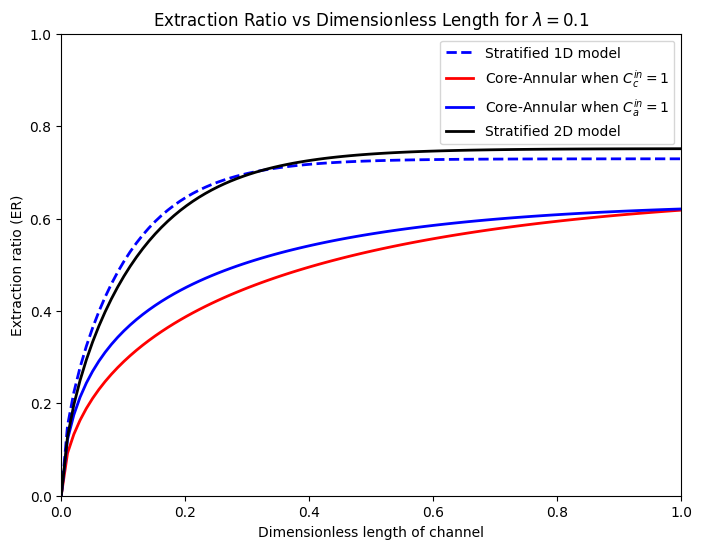

In [101]:
x_len, er_values = ER_1dstrat(0.7283, 3.0, 1.0,0.05, 0.5011, 114.75, 222.85, 0.1, 2.6667, 0.2703, -38.06, -17.42, 50, 50)
plt.figure(figsize=(8, 6))
plt.plot(x_len, er_values, 'b--', linewidth=2, label='Stratified 1D model')
x_len1, er_values1 = ER_coreannular(0.7283, 3.0, 2.6667, 0.7038, -35.27, -16.14, 2.19, 4.26, 0.2703, 0.16, 80, 80)
plt.plot(x_len1, er_values1, 'r', linewidth=2, label='Core-Annular when $C_{c}^{in} = 1$')
x_len2, er_values2 = ER_coreannular_ca(1.373, 0.333, 0.375, 0.2652, -6.61, -14.45, 4.26, 2.19, 0.2703, 0.055, 80, 80)
plt.plot(x_len2, er_values2, 'b-', linewidth=2, label='Core-Annular when $C_{a}^{in} = 1$')
x_len3, er_values3 = ER_2dstrat(0.7283, 3.0, 1.0,7, 0.51, 6.88, 13.37, 0.1, 2.6667, 0.2703, -4.12, -1.88, 25, 25, 15)
                                 #qr, mu_r, mu1,e, alpha_s, Pe1, Pe2, lamb, Dr, ks, g1, g2, N1, N2, Nz
plt.plot(x_len3, er_values3, 'k-', linewidth=2, label='Stratified 2D model')
plt.xlabel('Dimensionless length of channel')
plt.ylabel('Extraction ratio (ER)')
plt.title(r'Extraction Ratio vs Dimensionless Length for $\lambda = 0.1$')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()

## Extraction Ratios Figure 9a , λ = 1

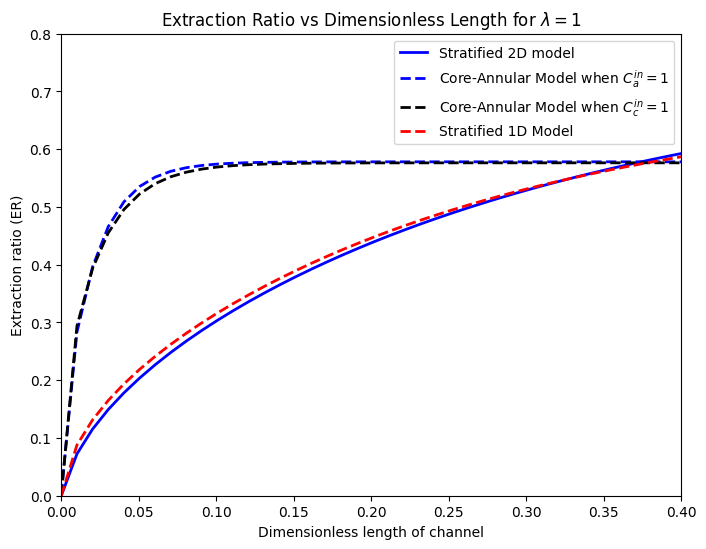

In [102]:
x_len, er_values = ER_1dstrat(0.6147, 3.0, 1.0,0.02, 0.5267, 72.96, 119.6, 1, 2.6667, 0.2703, -34.89, -18.92, 50, 50)
x_len1, er_values1 = ER_coreannular(0.6147, 3.0, 2.6667, 0.6780, -32.08, -17.4, 0.14, 0.23, 0.2703, 0.31, 80, 80)
x_len2, er_values2 = ER_coreannular_ca(1.6268, 0.333, 0.375, 0.45, -7.25, -13.37, 0.23, 0.14, 0.2703, 0.32, 80, 80)
x_len3, er_values3 = ER_2dstrat(0.6147, 3.0, 1,0.83, 0.505, 0.44, 0.72, 1, 2.6667, 0.2703, -80.95, -43.90, 25, 25, 15)
plt.figure(figsize=(8, 6))
plt.xlim([0,0.4])
plt.plot(x_len3, er_values3, 'b', linewidth=2, label = 'Stratified 2D model')
plt.plot(x_len2, er_values2, 'b--', linewidth=2, label = 'Core-Annular Model when $C_{a}^{in} = 1$')
plt.plot(x_len1, er_values1, 'k--', linewidth=2, label = 'Core-Annular Model when $C_{c}^{in} = 1$')
plt.plot(x_len, er_values, 'r--', linewidth=2, label='Stratified 1D Model')
plt.xlabel('Dimensionless length of channel')
plt.ylabel('Extraction ratio (ER)')
plt.title(r'Extraction Ratio vs Dimensionless Length for $\lambda = 1$')
plt.ylim([0,0.8])
plt.legend()
plt.show()

## Extraction Ratios Figure 9b , λ = 2.5

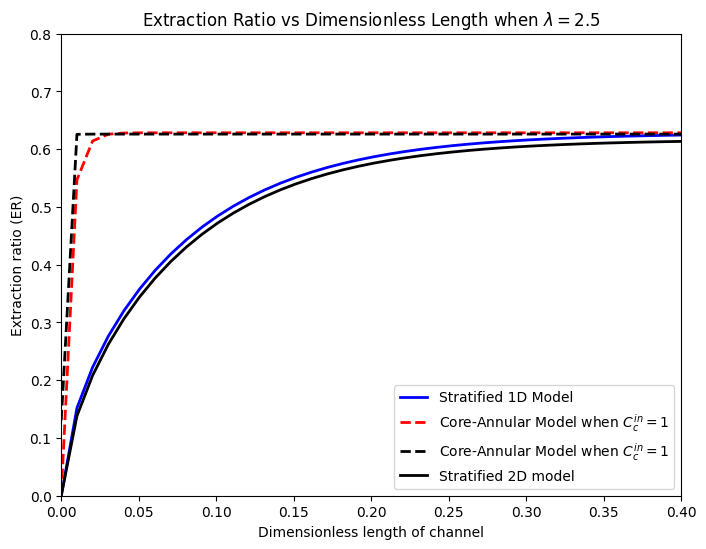

In [103]:
x_len, er_values = ER_1dstrat(0.4562, 3.0, 1.0, 0.0003,0.5703, 695.9, 846.7, 2.5, 2.6667, 0.2703, -31.40, -22.94,50,50)
x_len1, er_values1 = ER_coreannular(0.4562, 3, 2.667, 0.6313, -27.46, -20.07, 0.055, 0.067, 0.2703, 0.45, 80, 80)
x_len2, er_values2 = ER_coreannular_ca(2.192, 0.333, 0.375, 0.8196, -8.70, -11.90, 0.067, 0.055, 0.2703, 0.48, 80, 80)
x_len3, er_values3 = ER_2dstrat(0.4562, 3.0, 1.0,0.16, 0.55, 0.174, 0.211, 2.5, 2.6667, 0.2703, -593.83, -433.89, 25, 25, 15)
                                 #qr, mu_r, mu1,e, alpha_s, Pe1, Pe2, lamb, Dr, ks, g1, g2, N1, N2, Nz
plt.figure(figsize=(8, 6))
plt.xlim([0,0.4])
plt.ylim([0,0.8])
plt.plot(x_len, er_values, 'b-', linewidth=2, label='Stratified 1D Model')
plt.plot(x_len1, er_values1, 'r--', linewidth=2, label='Core-Annular Model when $C_{c}^{in} = 1$')
plt.plot(x_len2, er_values2, 'k--', linewidth=2, label='Core-Annular Model when $C_{c}^{in} = 1$')
plt.plot(x_len3, er_values3, 'k', linewidth=2, label='Stratified 2D model')
plt.xlabel('Dimensionless length of channel')
plt.ylabel('Extraction ratio (ER)')
plt.title(r'Extraction Ratio vs Dimensionless Length when $\lambda = 2.5$')
plt.legend()
plt.show()

## Extraction Ratios Figure 10

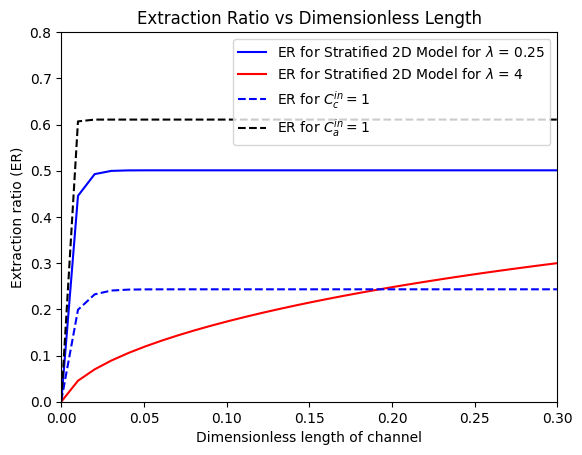

In [104]:
x_len1, er_values1 = ER_1dstrat(0.8760,1.667,1,1,0.5, 0.128, 0.766, 0.25, 6.9231, 0.8772, -8.8,-6.09, 25, 25)
x_len2, er_values2 = ER_1dstrat(0.6584, 1.6667, 1, 0.03, 0.5, 0.1504,0.6856, 4, 6.9231, 0.8772, -1912.40, -1742.73, 50, 50)
x_len3, er_values3 = ER_coreannular(0.2727, 1.6667, 6.9231, 0.7071, -14.55, -32.01, 0.124, 0.234, 0.8772, 0.3, 80, 80)
x_len4, er_values4 = ER_coreannular_ca(0.3846, 0.60, 0.1444, 0.7071, -7.38, -32.01, 1.01, 0.0562, 0.8772, 0.006, 80, 80)
plt.xlim([0, 0.3])
plt.ylim([0, 0.8])
plt.plot(x_len1, er_values1, 'b-', label=r'ER for Stratified 2D Model for $\lambda$ = 0.25')
plt.plot(x_len2, er_values2, 'r-', label=r'ER for Stratified 2D Model for $\lambda$ = 4')
plt.plot(x_len3, er_values3, 'b--', label=r'ER for $C^{in}_c = 1$')
plt.plot(x_len4, er_values4, 'k--', label=r'ER for $C^{in}_a = 1$')
plt.xlabel('Dimensionless length of channel')
plt.ylabel('Extraction ratio (ER)')
plt.title('Extraction Ratio vs Dimensionless Length')
plt.legend()
plt.show()